## Taylor-Green flow

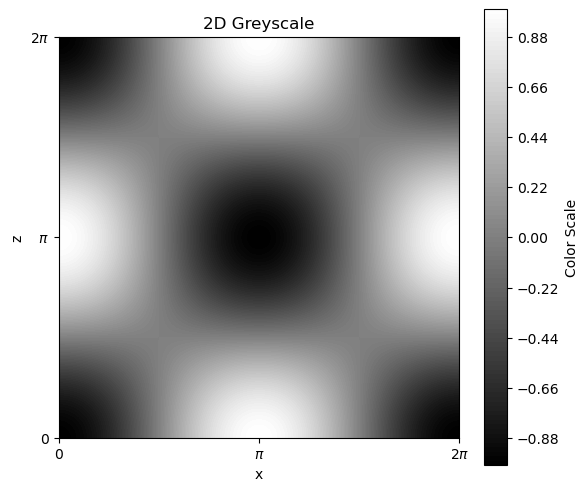

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def psi(x, z):
    return -np.cos(x) * np.cos(z)

# plot the function in 2D greyscale (x, z) -> f(x, z)
fig, ax = plt.subplots(figsize=(6,6))
X = np.linspace(0, 2*np.pi, 100)
Z = np.linspace(0, 2*np.pi, 100)
X, Z = np.meshgrid(X, Z)
Y = psi(X, Z)

contour = ax.contourf(X, Z, Y, 100, cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('z')

# set the tickers to only show pi and 2pi
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels(['0', '$\pi$', '$2\pi$'])
ax.set_yticks([0, np.pi, 2*np.pi])
ax.set_yticklabels(['0', '$\pi$', '$2\pi$'])
ax.set_aspect('equal')
ax.set_title('2D Greyscale')
# set bar to show the color scale
cbar = fig.colorbar(contour, shrink=0.8)
cbar.ax.set_ylabel('Color Scale')

plt.tight_layout()
plt.show()


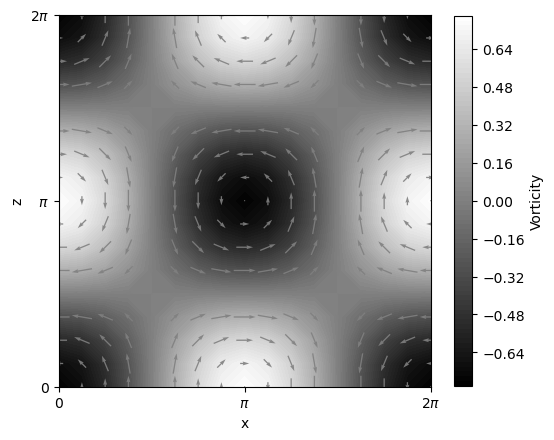

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def u(x, z):
    return -np.cos(x) * np.sin(z)

def v(x, z):
    return np.sin(x) * np.cos(z)

# define function w(u,v) caculate vorticity of the vector field
def w(u, v):# w = d(v)/dx - d(u)/dy
    return np.gradient(v, axis=1) - np.gradient(u, axis=0)

# plot the vector graph of Taylor-Green vortex
fig, ax = plt.subplots(figsize=(6,6))
X, Z = np.meshgrid(np.linspace(0, 2*np.pi, 17), np.linspace(0, 2*np.pi, 17))
U = u(X, Z)
V = v(X, Z)
contour = ax.contourf(X, Z, -w(U, V), 100, cmap='gray')
ax.quiver(X, Z, U, V, angles='uv', scale_units='xy', scale=2.5, pivot='mid', alpha=0.9, color='grey')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_aspect('equal')
# set the tickers to only show pi and 2pi
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels(['0', '$\pi$', '$2\pi$'])
ax.set_yticks([0, np.pi, 2*np.pi])
ax.set_yticklabels(['0', '$\pi$', '$2\pi$'])
cbar = fig.colorbar(contour,shrink=0.8)
cbar.ax.set_ylabel('Vorticity')
plt.show()


## Q-Learning for Swimmers

In [1]:
# Path: TGF.ipynb
# Reinforcement Learning
from pprint import pp
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import MultipleLocator, FuncFormatter
import matplotlib.pyplot as plt

# 定义涡场和动力学方程 Dynamics
# vorticity vector
def omega_hat(x, z, length = 1):
    if length == 1:
        return np.cos(x)*np.cos(z)
    elif length == 3:
        return np.array([0,0,np.cos(x)*np.cos(z)])

# flow field
def u_hat(x, z):
    return np.array([-np.cos(x)*np.sin(z)/2, np.sin(x)*np.cos(z)/2])

# transitional noise
def eta(): # eta = (eta_x, eta_z)
    return np.random.normal(0, 1, 2)

# rotational noise
def xi():
    return np.random.normal(0, 1)

# particle velocity direction
def p(theta_p, length = 2): # p = (p_x, p_z) (default) or (p_x, p_z, p_y) (length = 3)
    if length == 2:
        return np.array([np.cos(theta_p),np.sin(theta_p)])
    elif length == 3:
        return np.array([np.cos(theta_p),np.sin(theta_p),0])
    
# time evolution of particle position
def delta_X(x, z, theta_p, Phi, D0, u0): # delta_X = (delta_x, delta_z)
    return u0*(u_hat(x, z)+Phi*np.array([np.cos(theta_p),np.sin(theta_p)]))+np.sqrt(2*D0)*eta()

# time evolution of particle velocity direction
def delta_theta_p(x, z, theta_p, ka, Psi, B, DR):
    delta_p0 = 1/(2*B) * ((ka-np.dot(ka,p(theta_p))*p(theta_p))+Psi* np.cross(omega_hat(x, z, 3),p(theta_p, 3))[:2])
    return np.linalg.norm(delta_p0)+ np.sqrt(2*DR)*xi()

# Encoding
# Vorticity: dictOfVorticity = {0: "w-",1: "w0",2: "w+"}
# Direction: dictOfDirection = {0: "up",1: "left",2: "down",3: "right"}
# Actions: dictOfActions = {0: "up",1: "left",2: "down",3: "right"}

# 定义环境 RL Environment
class CustomEnv(gym.Env): # 继承gym.Env类 subclass of gym.Env
    # 初始化函数 initialize function
    def __init__(self,
                Phi = 0, # parameter Phi of position evolution
                Psi = 0, # parameter Psi of direction evolution
                B = 1, # parameter B of direction evolution
                u0 = 1, # speed of particle
                D0 = 1, # translational diffusion coefficient
                DR = 1, # rotational diffusion coefficient
                dt = 0.1 # time step
                ): 
        super(CustomEnv, self).__init__() # 必须调用父类的构造函数
        self.Phi = Phi
        self.Psi = Psi
        self.B = B
        self.u0 = u0
        self.D0 = D0
        self.DR = DR
        self.dt = dt
        # 定义观测空间, 状态空间和动作空间
        # Observation space will be a dict of two discrete values
        self.observation_space = spaces.Dict({
            "vorticity": spaces.Discrete(3),# dictOfVorticity.keys()
            "direction": spaces.Discrete(4)# dictOfDirection.keys()
        })
        # State space will be a dict of two continuous values
        self.low = np.array([0,0])
        self.high = np.array([2*np.pi,2*np.pi])
        self.state_space = spaces.Dict({
            "position" : spaces.Box(self.low, self.high, dtype=np.float32),
            "direction_theta_p": spaces.Box(low = 0, high = 2*np.pi, shape = (1,), dtype=np.float32)
            })
        # Action space will be a discrete set of 4 actions
        self.action_space = spaces.Discrete(4)# dictOfActions.keys()
        # 定义动作到方向的映射字典
        self._action_to_ka = {
            0: np.array([0, 1]),
            1: np.array([-1, 0]),
            2: np.array([0, -1]),
            3: np.array([1, 0]),
        }
        # 初始化状态和观测
        self.observation = self.reset()
        
    def reset(self, 
            seed = None, # random seed
            initial_position = None, # (optional) initial position, default is random
            initial_direction = None # (optional) initial direction, default is random
            ):    
        super().reset(seed=seed) # 重置环境   
        self.state = self.state_space.sample() # 初始化状态
        if initial_position is not None:
            self.state["position"] = initial_position.copy()
        if initial_direction is not None:
            self.state["direction_theta_p"] = initial_direction.copy()
        self.observation = self._get_obs()
        info = {'position': self.state['position']} # 初始化信息 
        return self.observation, info # 返回初始化状态
    
    def step(self, action):
        # dynamics
        ka = self._action_to_ka[action]
        delta_x = delta_X(
            self.state["position"][0], 
            self.state["position"][1], 
            self.state["direction_theta_p"][0], 
            self.Phi, 
            self.D0, 
            self.u0)
        self.state["position"] += delta_x*self.dt
        self.state["direction_theta_p"] += delta_theta_p(
            self.state["position"][0], 
            self.state["position"][1],
            self.state["direction_theta_p"][0], 
            ka, 
            self.Psi, 
            self.B, 
            self.DR
            )*self.dt
        self.state["direction_theta_p"] = self.state["direction_theta_p"] % (2*np.pi)
        # observation
        observation = self._get_obs()
        # reward
        reward = delta_x[1]*self.dt
        # terminated
        terminated = self.state['position'][1] - self.high[1] >= 0
        # truncated
        truncated = not(self.state_space.contains(self.state))
        info  = {'position': self.state['position']}
        return observation, reward, terminated, truncated, info
    
    def _get_obs(self):
        self.observation  = self.observation_space.sample()
        w = omega_hat(self.state["position"][0], self.state["position"][1])
        theta_p = self.state['direction_theta_p']
        # vorticity
        if w >= -1 and w < -0.33:
            self.observation["vorticity"] = 0
        elif w >= -0.33 and w <= 0.33:
            self.observation["vorticity"] = 1
        elif w > 0.33 and w <= 1:
            self.observation["vorticity"] = 2
        # direction
        if theta_p >= np.pi/4 and theta_p < 3*np.pi/4:
            self.observation["direction"] = 0
        elif theta_p >= 3*np.pi/4 and theta_p < 5*np.pi/4:
            self.observation["direction"] = 1
        elif theta_p >= 5*np.pi/4 and theta_p < 7*np.pi/4:
            self.observation["direction"] = 2
        else :
            self.observation["direction"] = 3
        return self.observation

# 定义智能体
class QLearningAgent:
    def __init__(self, env, 
        discount_factor=0.95, # 折扣因子 determines the importance of future rewards
        initial_learning_rate=0.1, # 初始学习率 determines how much we value new information compared to previous information
        learning_rate_decay=0.99, # 学习率衰减率 determines the rate at which we decay the learning rate
        initial_exploration_prob=0, # 初始探索率 determines the probability of taking a random action
        exploration_prob_decay = 0.995, # 探索率衰减率 determines the rate at which we decay the exploration probability
        num_episodes=1000, # 训练次数
        max_steps = 10000 # 最大步数
        ):
        self.env = env
        self.discount_factor = discount_factor
        self.learning_rate = initial_learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.exploration_prob = initial_exploration_prob
        self.exploration_decay = exploration_prob_decay
        self.num_episodes = num_episodes
        self.max_steps = max_steps
        self.n_state_dir = env.observation_space['direction'].n
        self.n_state_vor = env.observation_space['vorticity'].n
        self.n_actions = env.action_space.n
        self.Q = np.zeros((self.n_state_dir, self.n_state_vor, self.n_actions)) # + 1/(1-self.discount_factor)
        self.pos = []
        self.episode_lengths = np.zeros(self.num_episodes)
        self.episode_returns = np.zeros(self.num_episodes)
        self.trained_times = 0
    # 更新学习率
    def update_learning_rate(self):
        self.learning_rate *= self.learning_rate_decay
    # 更新探索率
    def update_exploration_prob(self):
        self.exploration_prob *= self.exploration_decay
    # 训练
    def train(self, 
            initial_position = None, # (optional) initial position, default is random
            initial_direction = None, # (optional) initial direction, default is random
            terminated = False, # 是否因为terminated而结束; whether to terminate the episode when terminated
            truncated = False # 是否因为truncated而结束; whether to terminate the episode when truncated
            ):
        for episode in range(self.num_episodes):
            state, info = self.env.reset(
                initial_position = initial_position, 
                initial_direction = initial_direction)
            done = False
            step = 0
            self.pos += [info['position'].copy()]
            # 一个 episode
            while not done:
                # 选择动作,例如 epsilon-greedy
                if np.random.rand() < self.exploration_prob:
                    action = self.env.action_space.sample()  # 随机动作
                else:
                    action = np.argmax(self.Q[state['direction'], state['vorticity'], :])  # 选择 Q 值最大的动作
                # 执行动作并观察环境
                next_state, reward, ter, tru, info = self.env.step(action)
                # 判断是否因为terminated或者truncated而结束 
                if terminated and ter:
                    done = True
                if truncated and tru:
                    done = True
                # 更新轨迹
                self.pos += [info['position'].copy()]
                # 更新 Q 值, Q(s,a) = (1-alpha) * Q(s,a) + alpha * (r + gamma * maxQ(s',a'))
                self.Q[state['direction'], state['vorticity'], action] = (1 - self.learning_rate) * self.Q[state['direction'], state['vorticity'], action] + \
                                   self.learning_rate * (reward + self.discount_factor * np.max(self.Q[next_state['direction'], next_state['vorticity'], :]))
                # 更新return
                self.episode_returns[episode] += reward
                # 更新状态
                state = next_state
                step+=1
                if step > (self.max_steps-1):            
                    break
            self.update_learning_rate()
            self.update_exploration_prob()
            # 更新episode length
            self.episode_lengths[episode] = step
            print('\r'+' '*40,end='')
            print(f'\rEpisode {episode + 1}/{self.num_episodes} length {step}', end='')
        self.trained_times += 1

# 定义类 Swimmer, 用于可视化训练后的智能体或者naive的智能体. 
# 输入末认为None, 即为naive的swimmer, action永远对应upward, 即ka = (0,1); 如果输入为训练好的q-learning agent, 则按照Q值选择动作.
class Swimmer:
    def __init__(self, env, max_steps=5000, agent=None):
        self.env = env # 环境
        self.agent = agent # 智能体
        self.max_steps = max_steps # 最大步数
        self.trajectories = [] # 轨迹
        self.lengths = [] # 轨迹长度
        self.returns = []
        self.avg_return = 0

    def swim(self, initial_position=None, initial_direction=None, num_episodes=100):
        for episode in range(num_episodes):
            state, info = self.env.reset(
                initial_position=initial_position,
                initial_direction=initial_direction) # 初始化状态
            done = False
            episode_return = 0
            trajectory = [info['position'].copy()] # 初始化轨迹
            step = 0
            while not done:
                if self.agent is None:
                    action = 0  # naive agent
                else:
                    action = np.argmax(self.agent.Q[state['direction'], state['vorticity'], :]) # 选择 Q 值最大的动作
                next_state, reward, _, _, info = self.env.step(action)
                episode_return += reward
                trajectory += [info['position'].copy()]
                state = next_state
                step += 1
                if  step >= (self.max_steps-1):
                    break
            self.returns.append(episode_return)
            self.trajectories.append(trajectory)
            self.lengths.append(len(trajectory))
            print('\r' + ' ' * 40, end='')
            print(f'\rEpisode {episode + 1}/{num_episodes} length {len(trajectory)}', end='')
        self.avg_return = np.mean(self.returns)
        return self.avg_return, self.trajectories

# Visualize
# 定义函数, 用于可视化轨迹
def plot_trajectories(trajectories, ax=None, title=None, color='k-',label=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    for trajectory in trajectories:
        ax.plot(*np.array(trajectory).T/np.pi, color, alpha=0.2,label=label)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_aspect('equal')
    ax.set_title(title)
    return ax

# 定义函数, 可视化训练过程中的episode length 和 return 变化 function to plot the episode lengths and returns
def moving_average(data, window_size):
    """ 计算移动平均 """
    ma = np.empty(len(data))
    for i in range(len(data)):
        # 对序列开始处使用不同长度的窗口
        window = data[max(0, i - window_size + 1):i + 1]
        ma[i] = np.mean(window)
    return ma
def plot_training_results(agent, smooth=1, plot_length=True, plot_return=True):
    episode_lengths = moving_average(agent.episode_lengths, smooth)
    episode_returns = moving_average(agent.episode_returns, smooth)
    
    num_subplots = 0
    if plot_length:
        num_subplots += 1
    if plot_return:
        num_subplots += 1 
    fig, ax = plt.subplots(1, num_subplots, figsize=(8*num_subplots, 8))
    if num_subplots == 1:
        ax = [ax]
    subplot_index = 0
    if plot_length:
        ax[subplot_index].plot(episode_lengths, color='blue', linestyle='-', label='Smoothed', linewidth=0.8)
        ax[subplot_index].scatter(range(len(agent.episode_lengths)), agent.episode_lengths, s=0.8, color='red', marker='o', label='Original')
        ax[subplot_index].set_xlabel('Episode')
        ax[subplot_index].set_ylabel('Episode Length')
        ax[subplot_index].legend()
        subplot_index += 1
    if plot_return:
        ax[subplot_index].plot(episode_returns, color='green', linestyle='-', label='Smoothed', linewidth=0.8)
        ax[subplot_index].scatter(range(len(agent.episode_returns)), agent.episode_returns, s=0.8, color='orange', marker='.', label='Original')
        ax[subplot_index].set_xlabel('Episode')
        ax[subplot_index].set_ylabel('Episode Return')
        ax[subplot_index].legend()   
    plt.tight_layout()
    plt.show()

#  定义函数, 用于可视化训练过程中的agent的轨迹
def format_func(value, tick_number): # define a function to format the tick labels
    N = int(np.round(value / np.pi))
    if N == 0:
        return '0'
    elif N == 1:
        return 'π'
    elif N == -1:
        return '-π'
    else:
        return f'{N}π'
def plot_training_trajectories(agent,ax,phase_size = 5000):
    pos = np.array(agent.pos)
    colors = np.arange(len(pos)) // phase_size  # 每个阶段颜色相同
    # plot the scatter plot
    scatter = ax.scatter(pos[:, 0], pos[:, 1], c=colors, cmap='viridis',s = 0.01)
    # add color bar
    sm = ScalarMappable(cmap='viridis')
    sm.set_array(colors)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Phase')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_aspect('equal')
    # Automatically determine the tick range based on the plot's drawing area
    ax.set_xlim(auto=True)
    ax.set_ylim(auto=True)
    # Set the tick format to integer multiples of pi
    ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))
    ax.yaxis.set_major_locator(MultipleLocator(base=np.pi))
    # Set the tick labels to Greek characters and nπ format
    ax.xaxis.set_major_formatter(FuncFormatter(format_func))
    ax.yaxis.set_major_formatter(FuncFormatter(format_func))
    plt.show()  

## Training Section

In [2]:
# def environment
env0 = CustomEnv(
    Phi= 0.3, 
    Psi=1, 
    B=1, 
    u0=1, 
    D0=0.001, 
    DR=0.0001, 
    dt=0.01)
# agent0: random initial position and direction
agent0 = QLearningAgent(
    env0, 
    discount_factor=0.997, 
    initial_learning_rate=0.09, 
    learning_rate_decay=0.999, 
    initial_exploration_prob=0.1, 
    exploration_prob_decay=0.995,
    num_episodes=5000,
    max_steps = 6000)
# agent1～agent3: initial position = (0,0), initial direction = (pi/2)
# agent1: before training, 0 episodes
agent1 = QLearningAgent(
    env0, 
    discount_factor=0.997, 
    initial_learning_rate=0.05, 
    learning_rate_decay=0.997, 
    initial_exploration_prob=0.1, 
    exploration_prob_decay=0.995,
    num_episodes=0,
    max_steps = 6000)
# agent2: during training, 500 episodes
agent2 = QLearningAgent(
    env0, 
    discount_factor=0.997, 
    initial_learning_rate=0.05, 
    learning_rate_decay=0.997, 
    initial_exploration_prob=0.1, 
    exploration_prob_decay=0.995,
    num_episodes=500,
    max_steps = 6000)
# agent3: after training, 3000 episodes
agent3 = QLearningAgent(
    env0, 
    discount_factor=0.997, 
    initial_learning_rate=0.05, 
    learning_rate_decay=0.997, 
    initial_exploration_prob=0.1, 
    exploration_prob_decay=0.995,
    num_episodes=3000,
    max_steps = 6000)

In [3]:
ini_pos = np.array([0.0,0.0])
ini_dir = np.array([np.pi/2])
agent0.train()
agent2.train(initial_position = ini_pos, initial_direction = ini_dir)
agent3.train(initial_position = ini_pos, initial_direction = ini_dir)

Episode 3000/3000 length 6000           

## Visualize training process

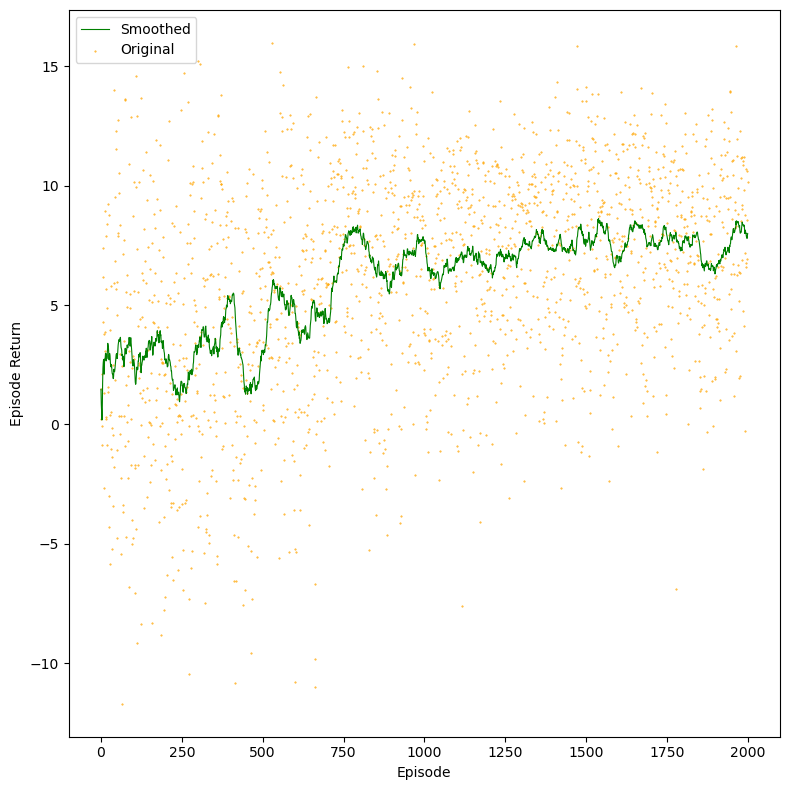

In [110]:
plot_training_results(agent0, 50, plot_length=False, plot_return=True)

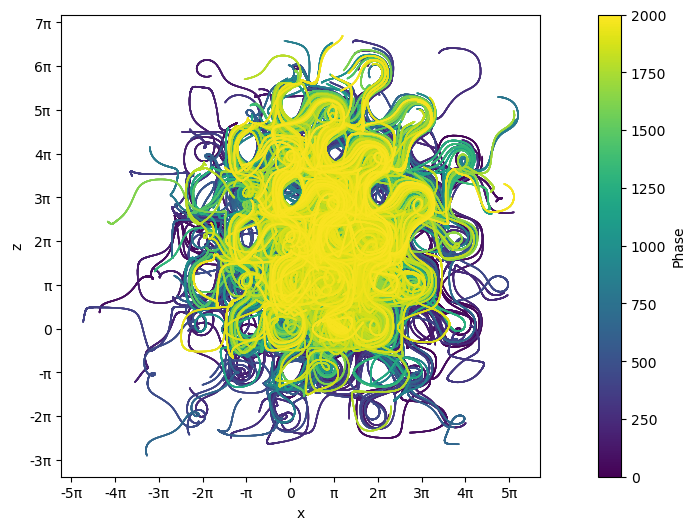

In [111]:
fig, ax = plt.subplots(1,1,figsize=(15,6))
plot_training_trajectories(agent0,ax,phase_size = 6000)

## Show training result

In [112]:
swimmer0 = Swimmer(env0,max_steps=10000) # naive swimmer
swimmer00 = Swimmer(env0,max_steps=10000,agent=agent0) # swimmer00 trained by agent0
swimmer01 = Swimmer(env0,max_steps=10000,agent=agent1) # swimmer01 trained by agent1
swimmer02 = Swimmer(env0,max_steps=10000,agent=agent2) # swimmer02 trained by agent2
swimmer03 = Swimmer(env0,max_steps=10000,agent=agent3) # swimmer03 trained by agent3

In [113]:
# Test: Each swimmer swims for 10 episodes.
ini_pos = np.array([0.0,0.0])
ini_dir = np.array([np.pi/2])
num_epi = 10
swimmer0.swim(initial_position=ini_pos,initial_direction=ini_dir,num_episodes=num_epi);
swimmer00.swim(initial_position=ini_pos,initial_direction=ini_dir,num_episodes=num_epi);
swimmer01.swim(initial_position=ini_pos,initial_direction=ini_dir,num_episodes=num_epi);
swimmer02.swim(initial_position=ini_pos,initial_direction=ini_dir,num_episodes=num_epi);
swimmer03.swim(initial_position=ini_pos,initial_direction=ini_dir,num_episodes=num_epi);

Episode 10/10 length 10000              

<Axes: title={'center': 'naive'}, xlabel='x', ylabel='z'>

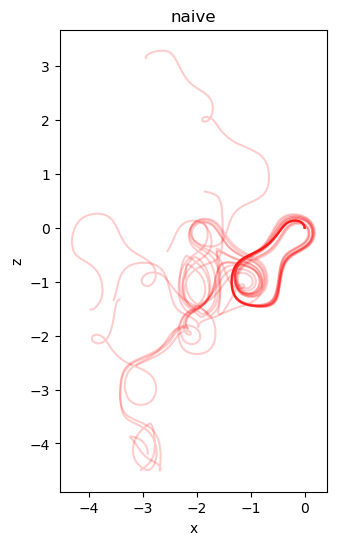

In [115]:
plot_trajectories(swimmer00.trajectories,title = 'naive',color='r-')

<Axes: xlabel='x', ylabel='z'>

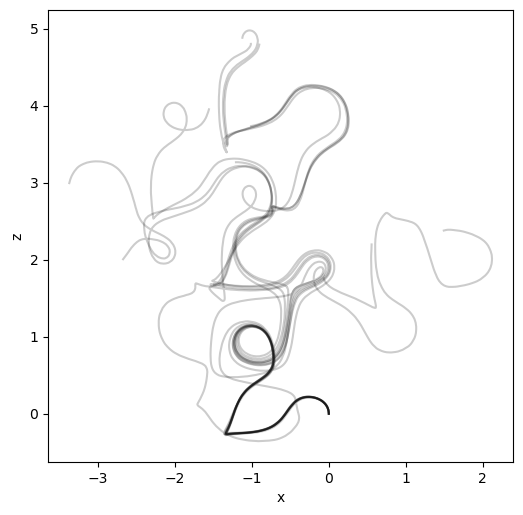

In [114]:
plot_trajectories(swimmer0.trajectories,label = '')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


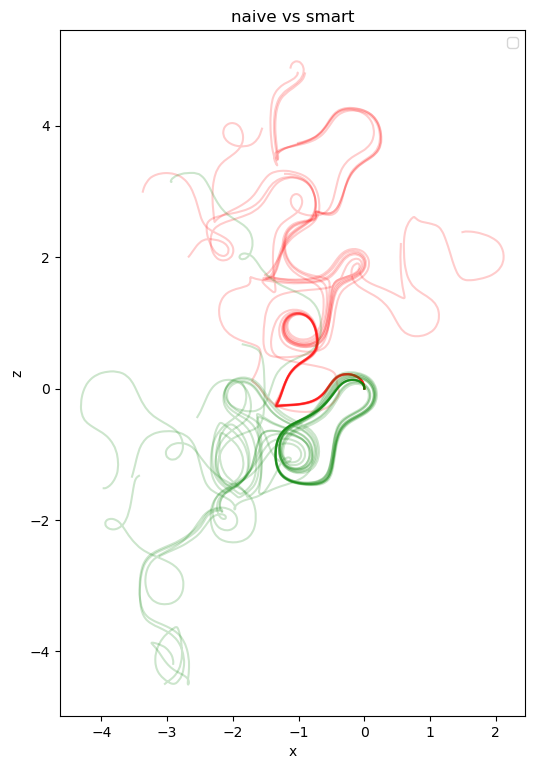

In [117]:
fig, ax = plt.subplots(figsize=(6,12))
plot_trajectories(swimmer0.trajectories[:],ax=ax,color='r-')
plot_trajectories(swimmer00.trajectories[:],ax = ax,title = 'naive vs smart',color='g-')
ax.legend()